# AIVLE스쿨 4기 DX트랙 5차 미니프로젝트 
## [미션#2] 중증질환 예측 데이터 분석

 [주의]
 * 본 자료는 임의로 가공된 응급 출동 데이터입니다. 의료적 소견이 전혀 없는 자료임을 참고해 주세요
 * 임의로 가공된 증상 및 중증 질환 결과를 할용하여, 증상에 따른 환자의 중증 질환을 예측하고자 합니다.


[미션] 
 * 증상 데이터 (Features) 와 중증 질환(Target)의 특징 파악 (단변량 분석)
 * 증상 데이터 (Features) 와 중증 질환(Target) 간의 관계 분석 (이변량 분석)
 * AI 모델링을 위한 데이터 전처리 

In [1]:
# 라이브러리 불러오기 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
# 응급 출동 데이터 불러오기
# 파일명 119_emergency_dispatch.csv, encoding='cp949'

data = pd.read_csv('119_emergency_dispatch.csv', encoding='cp949')
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,통증,만지면 아프다,무감각,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,0,0,0,0,0,1,0,0,심근경색,8
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,0,1,0,0,0,0,0,0,복부손상,40
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,0,1,0,0,0,0,0,0,복부손상,27
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,0,0,0,0,0,1,0,0,뇌경색,26
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,0,1,0,0,0,0,0,0,복부손상,62


### 1) 데이터셋(data)의 기초 정보 확인하기

In [3]:
# data 데이터프레임의 행, 열 개수 확인
data.shape

(17210, 23)

In [4]:
# data 데이터프레임의 컬럼명, 데이터 개수, 타입 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17210 entries, 0 to 17209
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        17210 non-null  object 
 1   출동일시      17210 non-null  object 
 2   이름        17210 non-null  object 
 3   성별        17210 non-null  object 
 4   나이        17210 non-null  int64  
 5   체온        17210 non-null  float64
 6   수축기 혈압    17210 non-null  int64  
 7   이완기 혈압    17210 non-null  int64  
 8   호흡 곤란     17210 non-null  int64  
 9   간헐성 경련    17210 non-null  int64  
 10  설사        17210 non-null  int64  
 11  기침        17210 non-null  int64  
 12  출혈        17210 non-null  int64  
 13  통증        17210 non-null  int64  
 14  만지면 아프다   17210 non-null  int64  
 15  무감각       17210 non-null  int64  
 16  마비        17210 non-null  int64  
 17  현기증       17210 non-null  int64  
 18  졸도        17210 non-null  int64  
 19  말이 어눌해졌다  17210 non-null  int64  
 20  시력이 흐려짐   17210 non-null  in

In [5]:
# data 데이터프레임의 하위 3개 행 확인
data.tail(3)

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,통증,만지면 아프다,무감각,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간
17207,P22512,2023-10-20,표**,여자,65,36.9,95,78,0,0,...,0,0,1,0,0,0,1,0,뇌출혈,18
17208,P24482,2023-10-20,채**,남자,14,36.3,105,72,0,0,...,0,0,1,0,0,0,1,0,뇌출혈,60
17209,P27091,2023-10-20,염**,남자,75,36.5,133,78,0,0,...,0,0,0,0,0,0,0,0,복부손상,5


In [6]:
# data 데이터프레임에 결측치 확인 isna(), sum()
# 결측치가 있는 경우, 삭제하기
data.isna().sum()


ID          0
출동일시        0
이름          0
성별          0
나이          0
체온          0
수축기 혈압      0
이완기 혈압      0
호흡 곤란       0
간헐성 경련      0
설사          0
기침          0
출혈          0
통증          0
만지면 아프다     0
무감각         0
마비          0
현기증         0
졸도          0
말이 어눌해졌다    0
시력이 흐려짐     0
중증질환        0
이송 시간       0
dtype: int64

### 2) 데이터 전처리

* 기존 컬럼을 이용하여 새로운 컬럼을 생성
* 추가해야 할 컬럼 내용
  * 연령구분 : 나이 컬럼을 활용하여 [신생아, 10대미만, 10대, 20대~ 80대, 90이상으로 구분]
  * 출동월 : 출동일시 컬럼을 활용하여 출동월을 추출
  * 발열 : 체온 컬럼을 활용하여, 37도 이상인 경우 1, 이하인 경우 0으로 구분
  * 고혈압 : 수축기 혈압 컬럼을 활용하여 140이상인 경우 1, 그렇지 않으면 0으로 구분
  * 저혈압 : 수축기 혈압 컬럼을 활용하여 90이하인 경우 1, 그렇지 않으면 0으로 구분
  

In [21]:
# 1) 연령구분 정보 구하기
# '나이' 컬럼을 활용하여 [신생아, 10대미만, 10대, 20대~ 80대, 90이상]으로 구분
bins = [-np.inf, 1, 9, 19, 29, 39, 49, 59, 69, 79, 89, np.inf]
label = ['신생아', '10대미만', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90이상']

data['연령구분'] = pd.cut(data['나이'], bins=bins, labels=label)
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,만지면 아프다,무감각,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,0,0,0,0,1,0,0,심근경색,8,60대
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,1,0,0,0,0,0,0,복부손상,40,80대
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,1,0,0,0,0,0,0,복부손상,27,20대
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,0,0,0,0,1,0,0,뇌경색,26,50대
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,1,0,0,0,0,0,0,복부손상,62,80대


In [22]:
# '연령구분' 컬럼의 고유한 값(범주)별 건수 확인하기 : value_counts()
data['연령구분'].value_counts()


80대      3115
70대      3031
60대      2189
50대      2161
40대      1724
30대      1657
10대      1178
10대미만     935
20대       720
90이상      402
신생아        98
Name: 연령구분, dtype: int64

In [23]:
from datetime import datetime

In [26]:
# 2) 출동월 정보 구하기
# 출동일자 컬럼에서 출동월 정보를 추출하기
month_list = []
for i in range(len(data)):
    month_list.append(datetime.strptime(data['출동일시'][i], '%Y-%m-%d').month)
    
data['출동월'] = month_list
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,무감각,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분,출동월
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,0,0,0,1,0,0,심근경색,8,60대,9
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,0,0,0,0,0,0,복부손상,40,80대,10
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,0,0,0,0,0,0,복부손상,27,20대,10
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,0,0,0,1,0,0,뇌경색,26,50대,10
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,0,0,0,0,0,0,복부손상,62,80대,10


In [29]:
# 3) 발열 정보 구하기
# 체온이 37도 이상이면 1, 그렇지 않으면 0

data['발열'] = [ 1 if x >=37 else 0 for x in data['체온']]
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분,출동월,발열
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,0,0,1,0,0,심근경색,8,60대,9,0
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,0,0,0,0,0,복부손상,40,80대,10,0
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,0,0,0,0,0,복부손상,27,20대,10,1
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,0,0,1,0,0,뇌경색,26,50대,10,0
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,0,0,0,0,0,복부손상,62,80대,10,1


In [30]:
# 4) 고혈압 정보 구하기
# 수축기 혈압 컬럼을 활용하여 140이상인 경우 1, 그렇지 않으면 0으로 구분

data['고혈압'] = [ 1 if x >=140 else 0 for x in data['수축기 혈압']]
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분,출동월,발열,고혈압
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,0,1,0,0,심근경색,8,60대,9,0,0
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,0,0,0,0,복부손상,40,80대,10,0,0
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,0,0,0,0,복부손상,27,20대,10,1,0
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,0,1,0,0,뇌경색,26,50대,10,0,0
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,0,0,0,0,복부손상,62,80대,10,1,0


In [31]:
# 5) 저혈압 정보 구하기
# 수축기 혈압이 90이하인 경우 1, 그렇지 않으면 0

data['저혈압'] = [ 1 if x <=90 else 0 for x in data['수축기 혈압']]
data.head()

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분,출동월,발열,고혈압,저혈압
0,P10715,2023-09-30,성**,여자,65,36.9,102,66,1,0,...,1,0,0,심근경색,8,60대,9,0,0,0
1,P10959,2023-10-26,표**,남자,86,36.7,106,72,0,0,...,0,0,0,복부손상,40,80대,10,0,0,0
2,P11863,2023-10-05,변**,여자,21,38.1,120,77,0,0,...,0,0,0,복부손상,27,20대,10,1,0,0
3,P12186,2023-10-17,도**,남자,57,36.5,129,75,0,0,...,1,0,0,뇌경색,26,50대,10,0,0,0
4,P15043,2023-10-01,송**,여자,88,39.1,103,65,0,0,...,0,0,0,복부손상,62,80대,10,1,0,0


### 3) 단변량 분석 - 범주형 데이터

* 대상 : 중증질환/연령구분

In [44]:
data[data['중증질환'] == '신생아']

,ID,출동일시,이름,성별,나이,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,...,졸도,말이 어눌해졌다,시력이 흐려짐,중증질환,이송 시간,연령구분,출동월,발열,고혈압,저혈압
646,P23733,2023-07-07,유**,여자,69,39.0,128,71,0,0,...,0,0,0,신생아,43,60대,7,1,0,0
3224,P24215,2023-06-19,시**,남자,69,37.8,98,67,0,0,...,0,0,0,신생아,24,60대,6,1,0,0
10194,P27159,2023-01-25,석**,여자,36,36.2,135,67,1,0,...,0,0,0,신생아,51,30대,1,0,0,0
10205,P19159,2023-01-26,천**,여자,85,36.1,124,74,0,1,...,0,0,0,신생아,16,80대,1,0,0,0
10368,P17887,2023-02-01,호**,여자,9,36.6,101,81,0,0,...,0,0,0,신생아,61,10대미만,2,0,0,0
10491,P26375,2023-02-05,음**,여자,60,39.1,110,78,0,0,...,0,0,0,신생아,53,60대,2,1,0,0
11408,P18175,2023-03-11,견**,남자,50,38.2,133,76,1,0,...,0,0,0,신생아,35,50대,3,1,0,0
15705,P26055,2023-08-23,윤**,남자,37,38.5,120,80,0,0,...,0,0,0,신생아,52,30대,8,1,0,0
16141,P20957,2023-09-09,추**,여자,41,36.9,131,83,0,0,...,0,0,0,신생아,43,40대,9,0,0,0


In [32]:
# 중증질환 통계
# '중증질환' 컬럼의 고유한 값(범주) 별 개수 카운트
data['중증질환'].value_counts()


복부손상    4608
뇌경색     4224
심근경색    4097
뇌출혈     4096
중증아님     151
조산산모      12
신생아        9
사지접합       7
중증화상       6
Name: 중증질환, dtype: int64

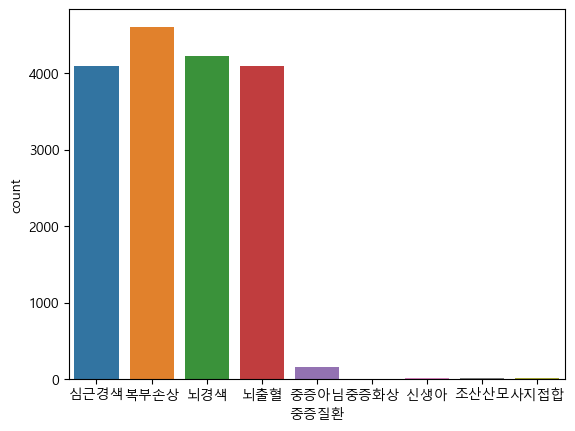

In [43]:
# seaborn 라이브러리의 countplot 함수을 사용하여 '중증질환' 컬럼의 범주별 개수 시각화 
sns.countplot(x = '중증질환', data = data)
plt.show()

* 중증 질환 중 [심근경색, 복부손상, 뇌경색, 뇌출혈]에 대한 자료만 추출하여 분석

In [47]:
# data 데이터프레임에서 '중증질환'값이 ['심근경색', '복부손상', '뇌경색', '뇌출혈'] 에 포함되는 경우만을 추출하여 desease 변수에 저장
# 이후 desease 데이터 프레임을 활용하여 분석

desease = data.loc[data['중증질환'].isin(['심근경색', '복부손상', '뇌경색', '뇌출혈'])]

In [48]:
# desease의 '중증질환' 컬럼의 고유한 값(범주) 별 개수 카운트

desease['중증질환'].value_counts()

복부손상    4608
뇌경색     4224
심근경색    4097
뇌출혈     4096
Name: 중증질환, dtype: int64

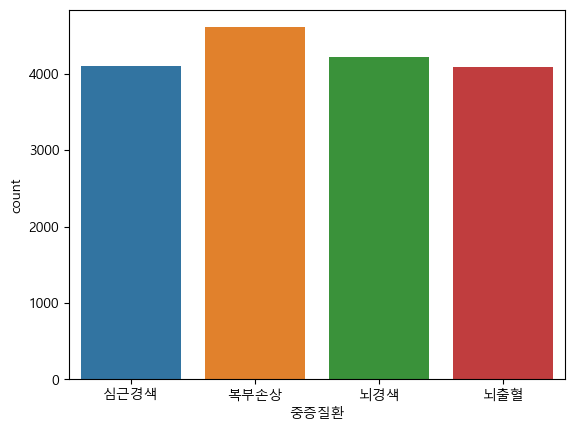

In [49]:
# seaborn 라이브러리의 countplot 함수을 사용하여 desease 데이터프레임의 '중증질환' 컬럼의 범주별 개수 시각화 
sns.countplot(x = '중증질환', data = desease)
plt.show()

In [ ]:
# 질문) 어느 중증질환에 출동 건수가 많았나요? 복부손상
# 질문) 중증질환별 출동 건수에 차이가 있나요? 큰 차이 없음


In [50]:
# '연령구분' 컬럼의 고유한 값(범주) 별 개수 카운트
data['연령구분'].value_counts()

80대      3115
70대      3031
60대      2189
50대      2161
40대      1724
30대      1657
10대      1178
10대미만     935
20대       720
90이상      402
신생아        98
Name: 연령구분, dtype: int64

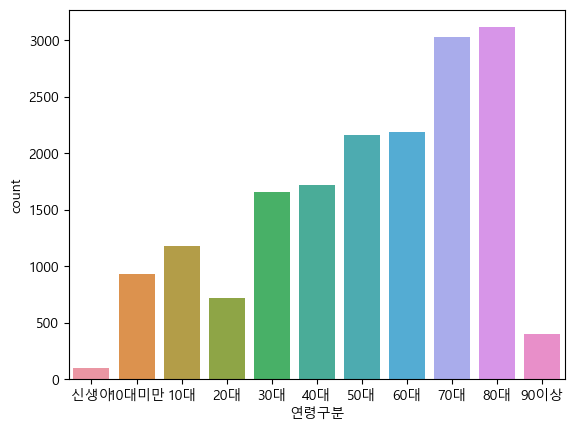

In [51]:
# seaborn 라이브러리의 countplot 함수을 사용하여 desease 데이터프레임의 '연령구분' 컬럼의 범주별 개수 시각화 
sns.countplot(x = '연령구분', data = data)
plt.show()


In [ ]:
#질문) 어느 연령대가 가장 많은가요? 80대
#질문) 연령대별로 출동 건수의 차이가 있나요? 고연령대로 갈수록 출동건수가 많다

### 4) 단변량 분석 - 숫자형 데이터
* 대상 : 체온

In [52]:
# 체온 컬럼에 대한 기초 통계 정보 확인하기, describe()
data[['체온']].describe().T


,count,mean,std,min,25%,50%,75%,max
체온,17210.0,36.608739,0.64943,36.0,36.2,36.5,36.8,39.9


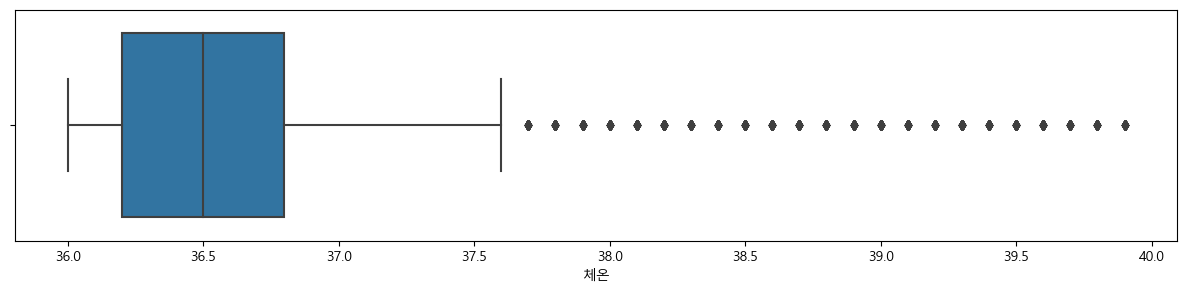

In [56]:
# seaborn의 boxplot을 이용하여 '체온' 컬럼의 분포를 시각화
plt.figure(figsize=(15, 3))
sns.boxplot(x='체온', data=data)
plt.show()

In [ ]:
# 질문) 체온 컬럼의 데이터 분포는 어떠한가? 정상체온 쪽에 많이 분포하지만 이상치도 많다
# 질문) 체온 컬럼의 데이터에 이상치가 존재하는가? 네
# 질문) 이상치 데이터는 제거해야 하는가? 아니면 유지해야 하는가? 환자에 대한 체온 데이터이므로 유지해야함



### 5) 이변량 분석 - 범주 vs 범주

 * Target : 중증 질환
 * Feature : 성별, 연령구분, 출동월, 증상 리스트

In [ ]:
# 1) Feature : 성별, Target : 중증 질환
# 가설 수립
# 귀무 가설 : 성별로 중증 질환에 차이가 없다
# 대립 가설 : 성별로 중증 질환에 차이가 있다.

In [69]:
# pandas의 crosstab을 이용하여 feature, target 범주값에 대한 교차 빈도 확인
# 변수명 : cross_sex
cross_sex = pd.crosstab(data['성별'], desease['중증질환'])

# 통계 검증 : 카이제곱 검증 (chi2_contingency) 
# 상관계수와 p-value 확인
chi2_sex = spst.chi2_contingency(cross_sex)

print(f'statistic:{chi2_sex.statistic}  pvalue={chi2_sex.pvalue}')

statistic:1.6323358900287734  pvalue=0.6520803009584115


In [ ]:
# 2) Feature : 연령 구분, Target : 중증 질환
# 가설 수립
# 귀무 가설 : 연령 구분대별로 중증 질환에 차이가 없다
# 대립 가설 : 연령 구분대별로 중증 질환에 차이가 있다.

In [70]:
# pandas의 crosstab을 이용하여 feature, target 범주값에 대한 교차 빈도 확인
# 변수명 : cross_age
cross_age = pd.crosstab(data['연령구분'], desease['중증질환'])


# 통계 검증 : 카이제곱 검증 (chi2_contingency) 
# 상관계수와 p-value 확인
chi2_age = spst.chi2_contingency(cross_age)

print(f'statistic:{chi2_age.statistic}  pvalue={chi2_age.pvalue}')

statistic:24.04802083723826  pvalue=0.7698475232224314


In [ ]:
# 3) Feature : 출동월, Target : 중증 질환
# 가설 수립
# 귀무 가설 : 출동월별로 중증 질환에 차이가 없다
# 대립 가설 : 출동월별로 중증 질환에 차이가 있다.

In [71]:
# pandas의 crosstab을 이용하여 feature, target 범주값에 대한 교차 빈도 확인
# 변수명 : cross_month
cross_month = pd.crosstab(data['출동월'], desease['중증질환'])


# 통계 검증 : 카이제곱 검증 (chi2_contingency) 
# 상관계수와 p-value 확인
chi2_month = spst.chi2_contingency(cross_month)

print(f'statistic:{chi2_month.statistic}  pvalue={chi2_month.pvalue}')

statistic:27.42678513398077  pvalue=0.6007840032980716


In [ ]:
# 4) Feature : 증상리스트, Target : 중증 질환
# 가설 수립
# 귀무 가설 : 각 증상별로 중증 질환에 차이가 없다
# 대립 가설 : 각 증상별로 중증 질환에 차이가 있다.

In [62]:
# 증상 리스트 

symptom = ['호흡 곤란', '간헐성 경련', '설사', '기침', '출혈', '통증', '만지면 아프다', '무감각', '마비', '현기증', '졸도',
       '말이 어눌해졌다', '시력이 흐려짐', '발열', '고혈압', '저혈압']

In [72]:
# for문을 이용하여 각 증상과 중증질환과의 카이제곱 검증 시행

for i in symptom:
    # pandas의 crosstab을 이용하여 feature, target 범주값에 대한 교차 빈도 확인
    # 변수명 : cross_sym
    cross_sym = pd.crosstab(data[i], desease['중증질환'])
    

    # 통계 검증 : 카이제곱 검증 (chi2_contingency) 
    # 상관계수와 p-value 확인
    chi2_sym = spst.chi2_contingency(cross_sym)
    print(i)
    print(f'statistic:{chi2_sym.statistic}  pvalue={chi2_sym.pvalue}')
   

    ## P-value (chi2_sym[1]) 값이 0.05보다 크면 귀무가설 채택, 0.05보다 작으면 대립가설 채택
    if chi2_sym.pvalue >= 0.05:
        print("귀무가설 채택",i, "에 따라 중증 질환에 차이가 없다.")
    else:
        print("대립가설 채택",i, "에 따라 중증 질환에 차이가 있다.")
    print('\n')

호흡 곤란
statistic:12143.468673526851  pvalue=0.0
대립가설 채택 호흡 곤란 에 따라 중증 질환에 차이가 있다.


간헐성 경련
statistic:1191.6349667012023  pvalue=4.787738645829797e-258
대립가설 채택 간헐성 경련 에 따라 중증 질환에 차이가 있다.


설사
statistic:2153.46475474655  pvalue=0.0
대립가설 채택 설사 에 따라 중증 질환에 차이가 있다.


기침
statistic:1075.098479705844  pvalue=9.191766041358234e-233
대립가설 채택 기침 에 따라 중증 질환에 차이가 있다.


출혈
statistic:2341.3786248181164  pvalue=0.0
대립가설 채택 출혈 에 따라 중증 질환에 차이가 있다.


통증
statistic:1690.2069197269511  pvalue=0.0
대립가설 채택 통증 에 따라 중증 질환에 차이가 있다.


만지면 아프다
statistic:6423.16430147901  pvalue=0.0
대립가설 채택 만지면 아프다 에 따라 중증 질환에 차이가 있다.


무감각
statistic:3834.7283281526084  pvalue=0.0
대립가설 채택 무감각 에 따라 중증 질환에 차이가 있다.


마비
statistic:6827.361020555932  pvalue=0.0
대립가설 채택 마비 에 따라 중증 질환에 차이가 있다.


현기증
statistic:3120.2033287659815  pvalue=0.0
대립가설 채택 현기증 에 따라 중증 질환에 차이가 있다.


졸도
statistic:2012.4331458605516  pvalue=0.0
대립가설 채택 졸도 에 따라 중증 질환에 차이가 있다.


말이 어눌해졌다
statistic:7526.849009582782  pvalue=0.0
대립가설 채택 말이 어눌해졌다 에 따라 중증 질환에 차이가 있다.


시력이 흐

In [ ]:
# 질문) 범주형 vc 범주형 이변량 분석 결과를 정리하세요
# 대부분 다 영향이 있다

### 6) 이변량 분석 - 숫자형 vc 범주형

 * Target : 중증 질환
 * Feature : 나이, 체온, 수축기 혈압, 이완기 혈압

In [ ]:
# 가설 수립
# 귀무 가설 : feature에 따라 중증 질환에 차이가 없다
# 대립 가설 : feature에 따라 중증 질환에 차이가 있다.

In [73]:
desease['중증질환'].unique()

array(['심근경색', '복부손상', '뇌경색', '뇌출혈'], dtype=object)

In [78]:
# anova 분석 대상 리스트 확인

anova_column = ['나이', '체온', '수축기 혈압', '이완기 혈압']

# for문을 이용하여 feature 데이터 하나씩 순차적으로 분석하기 
# 중증질환별로 feature 데이터를 분리하고, anova 검증 결과를 확인

for i in anova_column:
    # 중증질환별로 데이터 분리하기
    E_1 = desease.loc[desease['중증질환'] == '심근경색', i]
    E_2 = desease.loc[desease['중증질환'] == '복부손상', i]
    E_3 = desease.loc[desease['중증질환'] == '뇌경색', i]
    E_4 = desease.loc[desease['중증질환'] == '뇌출혈', i]


    # 통계 검증 : anova검증 (f_oneway)
    result = spst.f_oneway(E_1, E_2, E_3, E_4)

    # p-value 확인하기
    print(f'{i}: {result.pvalue}')
    print(result)
    

나이: 0.4032008856528455
F_onewayResult(statistic=0.9753355966078869, pvalue=0.4032008856528455)
체온: 1.1727742884213586e-128
F_onewayResult(statistic=201.8634441560383, pvalue=1.1727742884213586e-128)
수축기 혈압: 6.779786822766033e-05
F_onewayResult(statistic=7.310971381793122, pvalue=6.779786822766033e-05)
이완기 혈압: 2.7791745009929158e-08
F_onewayResult(statistic=12.692008838060291, pvalue=2.7791745009929158e-08)


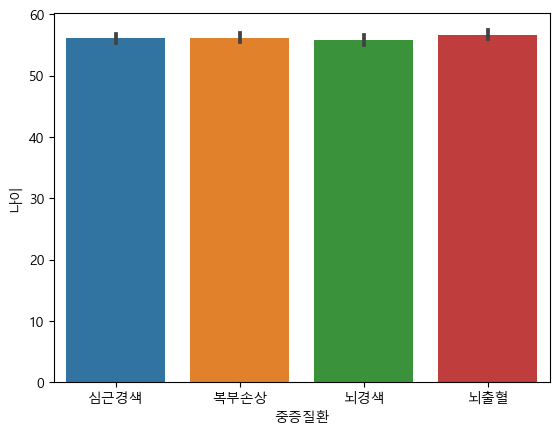

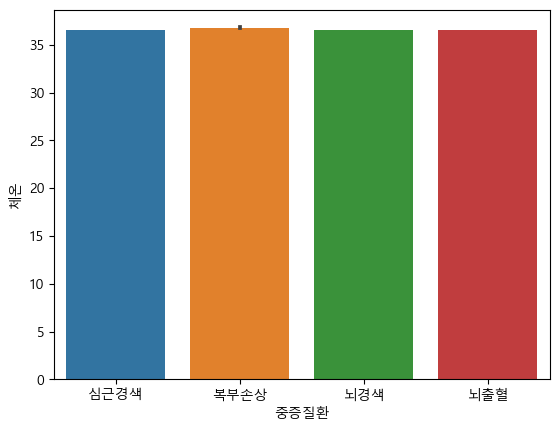

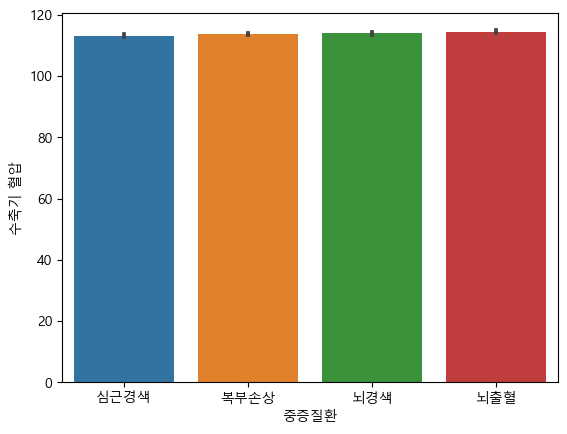

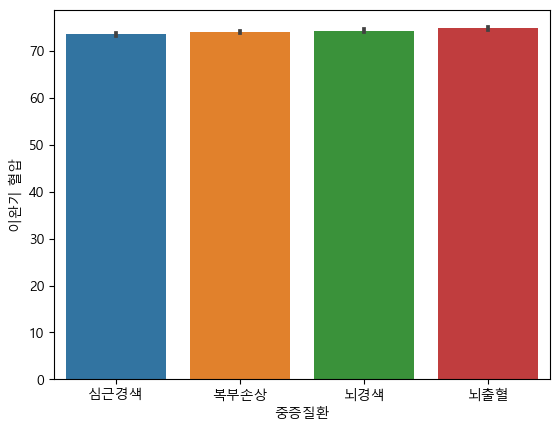

In [77]:
# for문을 이용하여 feature 데이터 하나씩 순차적으로 분석하기 
# seaborn의 barplot 활용하여 중증질환별 feature값 분포의 차이를 시각화

for i in anova_column:
    sns.barplot(x='중증질환', y=i, data=desease)
    plt.show()

In [ ]:
# 질문) 숫자형 vc 범주형 이변량 분석 결과를 정리하세요

# 다 영향이 있다

### 7) 데이터 분석 결과

In [ ]:
# 질문) 데이터 분석 결과, AI 모델링에 반영할 Feature는 무엇인가요?

# 모두 반영한다



### 8) 데이터 전처리 함수 만들기

 * 함수로 전처리 과정을 정의
   * 1. 함수 선언하기
   * 2. 데이터 전처리 하기 : 발열, 고혈압, 저혈압
   * 3. Y에 Target(중증질환) 값 넣기
   * 4. X에 위 분석 결과에서 선택된 Feature들 넣기
   * 5. X, Y 반환하기
 

In [92]:
#########################################
# 1. 함수 선언하기                       #
#########################################
# 함수명 : preprocessing
# 매개변수 : desease (응급 출동 데이터 중 중증 질환이 ['심근경색', '복부손상', '뇌경색', '뇌출혈']인 데이터프레임)

def preprocessing(desease):

    desease = desease.copy()
    #########################################
    # 2. 데이터 전처리 하기                  #
    #########################################
    
    # '발열' 컬럼 구하기 : 체온이 37도 이상이면 1, 아니면 0
    desease['발열'] = [ 1 if x >=37 else 0 for x in desease['체온']]

    # '고혈압' 칼럼 구하기 : 수축기 혈압이 140 이상이면 1, 아니면 0
    desease['고혈압'] = [ 1 if x >=140 else 0 for x in desease['수축기 혈압']]

    # '저혈압' 칼럼 구하기 : 수축기 혈압이 90 이하이면 1, 아니면 0
    desease['저혈압'] = [ 1 if x <=90 else 0 for x in desease['수축기 혈압']]
    

    #########################################
    # 3. X에 선택된 Feature값 넣기           #
    #########################################
    # X : '중증질환' 및 데이터분석에서 Target에 영향을 주지 않는 칼럼 제외한 나머지
    
    X = desease[[ '체온', '수축기 혈압', '이완기 혈압', '호흡 곤란', '간헐성 경련', '설사', '기침', '출혈', '통증', '만지면 아프다', '무감각', '마비', '현기증', '졸도', '말이 어눌해졌다', '시력이 흐려짐', '발열', '고혈압', '저혈압']]
    #########################################
    # 4. X 반환하기                       #
    #########################################
    return X


In [93]:
## 확인하기

data = pd.read_csv("./119_emergency_dispatch.csv", encoding="cp949" )
desease = data[data['중증질환'].isin(['심근경색', '복부손상', '뇌경색', '뇌출혈'])]

X = preprocessing(desease)
print(X.shape)
X.head()

(17025, 19)


,체온,수축기 혈압,이완기 혈압,호흡 곤란,간헐성 경련,설사,기침,출혈,통증,만지면 아프다,무감각,마비,현기증,졸도,말이 어눌해졌다,시력이 흐려짐,발열,고혈압,저혈압
0,36.9,102,66,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,36.7,106,72,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,38.1,120,77,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,36.5,129,75,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,39.1,103,65,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


## 미션#2 Clear
## 수고하셨습니다!!